In [1]:
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
import keras.backend as K
import random 
import numpy as np
import pandas as pd

from preprocessor import _imread as imread
from preprocessor import _imresize as imresize
from matplotlib import pyplot as plt
from keras.losses import categorical_crossentropy
import argparse
import glob
import os

from keras.utils import to_categorical
from PIL import Image


Using TensorFlow backend.


In [2]:
DATA_DIR = "data/UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
input_shape = (IM_WIDTH, IM_HEIGHT, 3)
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'female': 1, 'male': 0},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'asian': 2, 'black': 1, 'indian': 3, 'others': 4, 'white': 0})

In [3]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [4]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
attributes = list(map(parse_filepath, files))

data/UTKFace/61_1_20170109142408075.jpg.chip.jpg
data/UTKFace/39_1_20170116174525125.jpg.chip.jpg
data/UTKFace/61_1_20170109150557335.jpg.chip.jpg


In [5]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df = df[(df['age'] > 10) & (df['age'] < 65)]
df.head()

,age,gender,race,file
0,28.0,female,white,data/UTKFace/28_1_0_20170116164219746.jpg.chip...
1,24.0,female,white,data/UTKFace/24_1_0_20170117150731090.jpg.chip...
3,24.0,female,black,data/UTKFace/24_1_1_20170113003752421.jpg.chip...
4,26.0,female,indian,data/UTKFace/26_1_3_20170104235148954.jpg.chip...
5,51.0,male,white,data/UTKFace/51_0_0_20170117190825002.jpg.chip...


In [6]:
def preprocess_image(image, input_shape):
    image = imresize(image, input_shape[:2])
    image = image.astype('float32')
    image = image/255.0
    image = np.expand_dims(image, axis=0)
    return image

def predict(model, image):
    predictions = model.predict(image)
    return predictions

def FGSM(x, model, race_label, gender_label, alpha_1, alpha_2):
    sess = K.get_session()
    x_adv1 = x
    x_adv2 = x
    x_adv3 = x
    x_adv4 = x
    x_adv5 = x
    #alpha_1 = 1.
    #alpha_2 = -1.
    #print(list(map(lambda x: x.name, model.layers)))
    # dense7 -> layer before race output
    # dense8 -> layer before gender output
    # dense_7 = model.get_layer('dense_7').output
    # dense_7_grads = K.gradients(dense_7, model.input)

    # dense_8 = model.get_layer('dense_8').output
    # dense_8_grads = K.gradients(dense_8, model.input)

    # final_grads = tf.constant(alpha_1) * dense_7_grads + tf.constant(alpha_2) * dense_8_grads
    # grads = K.gradients(final_grads, model.input)
    
    # delta = K.sign(final_grads[0])
    
    race_output = model.get_layer('race_output').output
    print("race_output {}".format(race_output))
    gender_output = model.get_layer('gender_output').output
    print("gender_output {}".format(gender_output))

    race_loss = K.sum(categorical_crossentropy(race_label, race_output))
    gender_loss = K.sum(categorical_crossentropy(gender_label, gender_output))
    
    #race_loss_val, gender_loss_val = sess.run([race_loss, gender_loss], feed_dict={model.input: x})
    #print(race_loss_val, gender_loss_val)

    loss = alpha_1 * race_loss + alpha_2 * gender_loss
    grads = K.gradients(loss, model.input)
    delta = K.sign(grads[0])

    x_adv1 = x_adv1 + 0.1 * delta
    x_adv2 = x_adv2 + 0.2 * delta
    x_adv3 = x_adv3 + 0.3 * delta
    x_adv4 = x_adv4 + 0.4 * delta
    x_adv5 = x_adv5 + 0.5 * delta

    x_adv1 = K.clip(x_adv1, 0.0 ,1.0)
    x_adv2 = K.clip(x_adv2, 0.0 ,1.0)
    x_adv3 = K.clip(x_adv3, 0.0 ,1.0)
    x_adv4 = K.clip(x_adv4, 0.0 ,1.0)
    x_adv5 = K.clip(x_adv5, 0.0 ,1.0)

    gradients, x_adv1_array, x_adv2_array, x_adv3_array, x_adv4_array, x_adv5_array = sess.run([grads,
                                                                                                x_adv1,
                                                                                                x_adv2,
                                                                                                x_adv3,
                                                                                                x_adv4,
                                                                                                x_adv5],
                                                                                                feed_dict={model.input:x})
    #print('GRADIENT SUM:{}'.format(np.sum(gradients[0])))
    return x_adv1_array, x_adv2_array, x_adv3_array, x_adv4_array, x_adv5_array

def plot_adversarial(img_list):
    plt.figure(figsize=(8,8))
    eps = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    for n, img in enumerate(img_list):
        ax = plt.subplot(2,3,n+1)
        ax.set_title('Epsilon: {}'.format(eps[n]))
        plt.imshow(img[0])
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [7]:
sess = K.get_session()

In [8]:
def PGD(x, race_label, gender_label, alpha_1, alpha_2, eps, steps):
    x_adv = model.input
    race_output = model.get_layer('race_output').output
    gender_output = model.get_layer('gender_output').output

    race_loss = K.sum(categorical_crossentropy(race_label, race_output))
    gender_loss = K.sum(categorical_crossentropy(gender_label, gender_output))

    loss = alpha_1 * race_loss + alpha_2 * gender_loss
    grads = K.gradients(loss, model.input)
    delta = K.sign(grads[0])

    x_adv = x_adv + eps * delta
    x_adv = K.clip(x_adv, 0.0, 1.0)

    for step in range(steps):
        # predictions = predict(model, x)
        # print(predictions)
        # print(x.shape)
        x_adv_array = sess.run([x_adv], feed_dict={model.input: x})
        # print(x_adv_array[0].shape)
        x = x_adv_array[0]
        #break
    return x_adv_array[0]

In [34]:
adv_model_path = "./models/VGG16_adv_model.h5"
clean_model_path = "./models/weighted_forked_VGG_model.h5"

In [ ]:
def get_adv_samples(x, model):
    adv_sample = FGSM(x, model)

In [36]:
def save_all_adv_samples(generator, eps):
    folder = "adv_generated_imgs_pgd"
    for data in generator:
        samples, labels, filenames = data
        race_one_hot, gender_one_hot = labels[1], labels[2]
        # running loop over a batch
        # prediction = predict(model, samples)

        adv_samples = PGD(samples, race_label=race_one_hot, gender_label=gender_one_hot,
                          alpha_1=0.1, alpha_2=-1., eps=eps, steps=20)
        for index in range(len(adv_samples)):
            filename = filenames[index]
            final_name = "{}/{}/{}/{}".format(filename.split("/")[0], folder, eps, filename.split("/")[-1])
            img = Image.fromarray(np.uint8(adv_samples[index]*255))
            img.save(final_name)
            
            """final_name = "{}/{}/{}/{}".format(filename.split("/")[0], folder, "1", filename.split("/")[-1])
            img = Image.fromarray(np.uint8(adv_samples[0][index]*255))
            img.save(final_name)

            final_name = "{}/{}/{}/{}".format(filename.split("/")[0], folder, "2", filename.split("/")[-1])
            img = Image.fromarray(np.uint8(adv_samples[1][index]*255))
            img.save(final_name)

            final_name = "{}/{}/{}/{}".format(filename.split("/")[0], folder, "3", filename.split("/")[-1])
            img = Image.fromarray(np.uint8(adv_samples[2][index]*255))
            img.save(final_name)

            final_name = "{}/{}/{}/{}".format(filename.split("/")[0], folder, "4", filename.split("/")[-1])
            img = Image.fromarray(np.uint8(adv_samples[3][index]*255))
            img.save(final_name)

            final_name = "{}/{}/{}/{}".format(filename.split("/")[0], folder, "5", filename.split("/")[-1])
            img = Image.fromarray(np.uint8(adv_samples[4][index]*255))
            img.save(final_name)"""
    return

In [40]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    # filenames variable is not being passed right now for the evaluation but would be
    # required if we want to generate the dataset of adversarial images
    images, ages, races, genders, filenames = [], [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            filenames.append(file)
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)], filenames
                images, ages, races, genders, filenames = [], [], [], [], []
        if not for_training:
            break

In [12]:
# random seed is not common with model training on the other notebook
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
test_idx = p[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()

In [41]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)

In [38]:
model = load_model(clean_model_path)

In [14]:
def random_image(sample_num=None):
    if sample_num is None:
        random_record = df.sample().iloc[0]
    else:
        random_record = df.iloc[sample_num]
    
    img_path = random_record['file']
    image = imread(img_path)
    image = preprocess_image(image, input_shape)

    race_label = random_record['race_id']
    gender_label = random_record['gender_id']

    race_one_hot = np_utils.to_categorical(race_label, len(ID_RACE_MAP))
    gender_one_hot = np_utils.to_categorical(gender_label, len(ID_GENDER_MAP))

    return image, gender_one_hot, race_one_hot

In [85]:
def perturbed_random_image(eps, index, sample_num=None):
    #index = np.random.choice(indices)
    #if sample_num is None:
    #    random_record = df.sample().iloc[0]
    #else:
    random_record = df.iloc[index]

    file = random_record['file']
    folder = "adv_generated_imgs_pgd"
    filename = "./{}/{}/{}/{}".format(file.split("/")[0], folder, str(eps), file.split("/")[-1])

    image = imread(filename)
    image = preprocess_image(image, input_shape)

    race_label = random_record['race_id']
    gender_label = random_record['gender_id']

    race_one_hot = np_utils.to_categorical(race_label, len(ID_RACE_MAP))
    gender_one_hot = np_utils.to_categorical(gender_label, len(ID_GENDER_MAP))

    return image, gender_one_hot, race_one_hot

In [ ]:
image, gender_one_hot, race_one_hot = random_image(114)

predictions = predict(model, image)

images = FGSM(image, model, race_one_hot, gender_one_hot, alpha_1 = 1., alpha_2 = 0.)

plot_adversarial(images)

In [90]:
race = [0,0,0,0]
gender = [0,0]
for idx in test_idx:
    image, gender_one_hot, race_one_hot = perturbed_random_image(0.2, idx)

    #predictions = predict(model, image)
    
    # images = FGSM(image, model, race_one_hot, gender_one_hot, alpha_1 = 10., alpha_2 = -10.)
    # image = PGD(image, race_one_hot, gender_one_hot, alpha_1 = 1., alpha_2 = -1., eps=0.1, steps=20)
    out = model.predict(image)
    #print(out[1], out[2])
    #print(predi)
    #plot_adversarial(image)
    race[np.argmax(out[1])] += 1
    gender[np.argmax(out[2])] += 1

KeyboardInterrupt: 

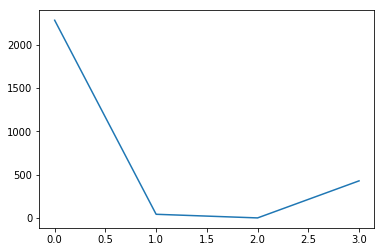

In [91]:
plt.plot(race)

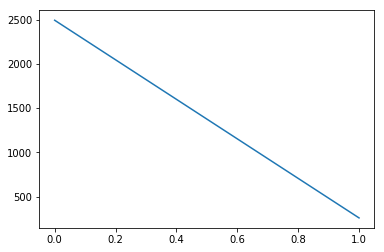

In [92]:
plt.plot(gender)

In [94]:
race

[2283, 42, 0, 428]

In [96]:
float(race[0]) / sum(race)

0.8292771521976026

In [98]:
len(test_idx)

5559

In [105]:
race = [0, 0, 0, 0, 0]
gender = [0, 0]

In [106]:
for idx in test_idx[:2753]:
    rec = df.iloc[idx]
    #print(rec['race_id'])
    gender[rec['gender_id']] += 1
    race[rec['race_id']] += 1
print(race)

[1078, 640, 323, 530, 182]


In [104]:
float(race[0]) / sum(race)

0.3915728296403923

In [108]:
gender

[1455, 1298]

In [107]:
float(gender[0]) / sum(gender)

0.5285143479840174

In [66]:
save_all_adv_samples(test_gen, eps=0.2)

## Evaluate clean model

In [24]:
def get_adv_data_generator(df, indices, eps, for_training=False, batch_size=128):
    images, ages, races, genders = [], [], [], []
    folder = "adv_generated_imgs_pgd"
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            filename = "{}/{}/{}/{}".format(file.split("/")[0], folder, str(eps), file.split("/")[-1])
            #if os.path.exists(filename):
            im = Image.open(filename)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                #print("yielded")
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [ ]:
# create a pandas data frame of images, age, gender and race
ADV_DATA_DIR = "./data/adv_generated_imgs_pgd/0.2/"
files = glob.glob(os.path.join(ADV_DATA_DIR, "*.jpg"))
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df = df[(df['age'] > 10) & (df['age'] < 65)]
#df.head()

# random seed is not common with model training on the other notebook
test_idx = np.random.permutation(len(df))
#train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
#test_idx = p[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()

#test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=32)

In [ ]:
# load clean model
model_path = "./models/weighted_forked_VGG_model.h5"
model = load_model(model_path)

In [21]:
# eps = 0
# test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{u'age_output_loss': 0.011946349404752254,
 u'age_output_mae': 0.0805635079741478,
 u'gender_output_accuracy': 0.976017415523529,
 u'gender_output_loss': 0.12335702776908875,
 'loss': 0.6523380279541016,
 u'race_output_accuracy': 0.8800871968269348,
 u'race_output_loss': 0.5985112190246582}

## Evaluation of VGG16 Model

In [43]:
eps = 0.2
test_gen = get_adv_data_generator(df, test_idx, eps, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{u'age_output_loss': 0.0446450412273407,
 u'age_output_mae': 0.15803809463977814,
 u'gender_output_accuracy': 0.9980014562606812,
 u'gender_output_loss': 0.03714361414313316,
 'loss': 1463.7095947265625,
 u'race_output_accuracy': 0.0,
 u'race_output_loss': 1486.427734375}

## Evaluation of ResNet50 Model

In [44]:
# load clean model
model_path = "./models/resnet50_model.h5"
model = load_model(model_path)

In [45]:
#eps = 0.2
test_gen = get_adv_data_generator(df, test_idx, eps, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{u'age_output_loss': 0.10832329839468002,
 u'age_output_mae': 0.2706315815448761,
 u'gender_output_accuracy': 0.5268895626068115,
 u'gender_output_loss': 7.587944030761719,
 'loss': 19.445199966430664,
 u'race_output_accuracy': 0.39662063121795654,
 u'race_output_loss': 13.472764015197754}

In [46]:
# load clean model
model_path = "./models/mobilenet_model.h5"
model = load_model(model_path)

In [47]:
test_gen = get_adv_data_generator(df, test_idx, eps, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{u'age_output_loss': 0.04689286649227142,
 u'age_output_mae': 0.1844833493232727,
 u'gender_output_accuracy': 0.4505814015865326,
 u'gender_output_loss': 1.069699764251709,
 'loss': 6.1234564781188965,
 u'race_output_accuracy': 0.39643895626068115,
 u'race_output_loss': 4.847633361816406}

## Evaluation of MobileNet Model

In [30]:
# load clean model
model_path = "./models/mobilenet_model.h5"
model = load_model(model_path)

In [31]:
test_gen = get_adv_data_generator(df, test_idx, eps, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{u'age_output_loss': 0.04766557365655899,
 u'age_output_mae': 0.18656139075756073,
 u'gender_output_accuracy': 0.4596656858921051,
 u'gender_output_loss': 1.053579568862915,
 'loss': 6.033567428588867,
 u'race_output_accuracy': 0.39662063121795654,
 u'race_output_loss': 4.8335862159729}

## Evaluation of VGG19 Model

In [48]:
# load clean model
model_path = "./models/vgg19_model.h5"
model = load_model(model_path)

In [49]:
test_gen = get_adv_data_generator(df, test_idx, eps, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{u'age_output_loss': 0.06575646996498108,
 u'age_output_mae': 0.207205668091774,
 u'gender_output_accuracy': 0.5401526093482971,
 u'gender_output_loss': 1.6036206483840942,
 'loss': 5.338807582855225,
 u'race_output_accuracy': 0.3088662922382355,
 u'race_output_loss': 3.3931243419647217}

In [ ]:
eps = 2
test_gen = get_adv_data_generator(df, test_idx, eps, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

In [ ]:
eps = 3
test_gen = get_adv_data_generator(df, test_idx, eps, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

In [ ]:
eps = 4
test_gen = get_adv_data_generator(df, test_idx, eps, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

In [ ]:
eps = 5
test_gen = get_adv_data_generator(df, test_idx, eps, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

In [ ]:
#print(df[(df.gender == 'female') & (df.race == 'black')].file)# and race == black']